## 0. Libarary 불러오기 및 경로설정

`!pip install -U albumentations==0.5.2`

`!pip install timm`

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import time
import datetime
import albumentations
import timm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from PIL import Image
from copy import deepcopy
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score
from pytz import timezone
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.nn.modules.loss import _WeightedLoss

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
print('PyTorch version: {}'.format(torch.__version__))

PyTorch version: 1.7.1


In [4]:
# 부를 수 있는 모델 확인
all_vit_models = timm.list_models('*efficient*')
all_vit_models

['eca_efficientnet_b0',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_b8',
 'efficientnet_cc_b0_4e',
 'efficientnet_cc_b0_8e',
 'efficientnet_cc_b1_8e',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_l2',
 'efficientnet_lite0',
 'efficientnet_lite1',
 'efficientnet_lite2',
 'efficientnet_lite3',
 'efficientnet_lite4',
 'efficientnetv2_l',
 'efficientnetv2_m',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_s',
 'gc_efficientnet_b0',
 'tf_efficientnet_b0',
 'tf_efficientnet_b0_ap',
 'tf_efficientnet_b0_ns',
 'tf_efficientnet_b1',
 'tf_efficientnet_b1_ap',
 'tf_efficientnet_b1_ns',
 'tf_efficientnet_b2',
 'tf_efficientnet_b2_ap',
 'tf_efficien

## RANDOM SEED 고정

In [5]:
def set_seed(SEED):
    # Set random seed
    # random.seed(SEED)
    np.random.seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

## Pretrained Model Class 정의

In [6]:
class ImgClassifier(nn.Module):
    def __init__(self, model_name, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''
    def forward(self, x):
        x = self.model(x)
        return x

## Fine Tuning & Feature extractor 설정 함수 정의

In [7]:
def set_model_train_mode(model, mode=0):
    # Fine Tuning
    if mode == 0:
        for param in model.parameters():
            param.requires_grad = True
    # Feature extractor
    elif mode == 1:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True
    else:
        raise Exception('mode를 0: Fine Tuning 1: Feature extractor 를 위한 parameter를 넣으세요!')

## Dataset Class 정의

In [8]:
class MyDataset(Dataset):
    def __init__(self, df, transform):
        self.img_paths = df['image_path']
        self.transform = transform
        self.y = df['target']

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        image = np.array(Image.open(self.img_paths.iloc[idx]))
        label = self.y.iloc[idx]

        if self.transform:
            image = self.transform(image=image)
            image = image['image']
        return image, torch.tensor(label)

## 데이터 Augmentation 을 위한 transform 정의 (albumentations 사용)

In [97]:
def get_transform(mean, std):
    train_transform = albumentations.Compose([
        albumentations.Resize(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, p=1.0),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.ShiftScaleRotate(p=0.5),
        albumentations.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        albumentations.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        albumentations.GaussNoise(p=0.5),
        albumentations.Normalize(mean, std, max_pixel_value=255.0, p=1.0),
        albumentations.CoarseDropout(p=0.5),
        albumentations.Cutout(p=0.5),
        ToTensorV2(p=1.0),
    ])
    valid_transform = albumentations.Compose([
        albumentations.Resize(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE),
        albumentations.Normalize(mean, std, max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0),
    ])
    return train_transform, valid_transform

## 3. Train DataLoader 정의

In [10]:
class MyDataset(Dataset):
    def __init__(self, df, transform):
        self.img_paths = df['image_path']
        self.transform = transform
        self.y = df['target']

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        image = np.array(Image.open(self.img_paths.iloc[idx]))
        label = self.y.iloc[idx]

        if self.transform:
            image = self.transform(image=image)
            image = image['image']
        return image, torch.tensor(label)

In [11]:
def get_dataloader(df, train_idx, valid_idx, mean, std):
    
    train_ = df.iloc[train_idx].reset_index(drop=True)
    valid_ = df.iloc[valid_idx].reset_index(drop=True)
    
    train_transform, valid_transform = get_transform(mean, std)
    
    train_dataset = MyDataset(train_, train_transform)
    valid_dataset = MyDataset(valid_, valid_transform)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=cfg.BATCH_SIZE,
                                               drop_last=False,
                                               shuffle=True,
                                               num_workers=cfg.NUM_WORKERS)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                               batch_size=cfg.BATCH_SIZE,
                                               drop_last=False,
                                               shuffle=True,
                                               num_workers=cfg.NUM_WORKERS)
    
    return train_loader, valid_loader

## EarlyStopping Class 정의

In [30]:
class EarlyStopping:
    """Early stops the training if validation accuracy doesn't improve after a given patience."""
    def __init__(self, patience=5, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation accuracy improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_acc_min = 0

    def __call__(self, val_acc, model, fold):

        score = -val_acc

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_acc, model, fold)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_acc, model, fold)
            self.counter = 0

    def save_checkpoint(self, val_acc, model, fold):
        '''Saves model when validation acc increase.'''
        if self.verbose:
            print(f'Validation acc increased ({self.val_acc_min:.6f} --> {val_acc:.6f}).  Saving model ...')
        path = f'{os.path.join(cfg.model_save_path, cfg.model_name)}_{fold + 1}'
        my_make_dir(path)
        torch.save(model.state_dict(), os.path.join(path, 'checkpoint.pt'))
        self.val_acc_min = val_acc

## Train_one_epoch 함수 정의

In [31]:
def train_one_epoch(epoch, model, criterion, optimizer, train_loader, device):
    model.train()
    
    running_loss = 0
    running_acc = 0
    running_f1 = 0
    
    pbar = tqdm(train_loader, total=len(train_loader))
    for X_batch, y_batch in pbar:
        pbar.set_description(f'Epoch {epoch} | loss : {running_loss:.4f} | acc : {running_acc:.4f} | F1_score : {running_f1:.4f}')

        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).long()
        
        optimizer.zero_grad()
        
        y_pred = model.forward(X_batch)
        _, preds = torch.max(y_pred, 1)
        loss = criterion(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() / len(y_batch)
        running_acc += torch.sum(preds == y_batch.data) / len(y_batch)
        running_f1 += f1_score(preds.cpu().numpy(), 
                                     y_batch.cpu().numpy(), average='macro')
        
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_acc / len(train_loader)
    epoch_f1 = running_f1 / len(train_loader)
    
    return epoch_loss, epoch_acc, epoch_f1

## Valid_one_epoch 함수 정의

In [32]:
def valid_one_epoch(epoch, model, criterion, valid_loader, device):
    model.eval()
    
    running_loss = 0
    running_acc = 0
    running_f1 = 0
    
    pbar = tqdm(valid_loader, total=len(valid_loader))
    with torch.no_grad():
        for X_batch, y_batch in pbar:
            pbar.set_description(f'Epoch {epoch} | loss : {running_loss:.4f} | acc : {running_acc:.4f} | F1_score : {running_f1:.4f}')
            
            X_batch = X_batch.to(device).float()
            y_batch = y_batch.to(device).long()
            
            y_pred = model.forward(X_batch)
            _, preds = torch.max(y_pred, 1)
            loss = criterion(y_pred, y_batch)
            
            running_loss += loss.item() / len(y_batch)
            running_acc += torch.sum(preds == y_batch.data) / len(y_batch)
            running_f1 += f1_score(preds.cpu().numpy(), 
                                     y_batch.cpu().numpy(), average='macro')
            
    epoch_loss = running_loss / len(valid_loader)
    epoch_acc = running_acc / len(valid_loader)
    epoch_f1 = running_f1 / len(valid_loader)
    
    return epoch_loss, epoch_acc, epoch_f1

## 폴더 자동 생성 함수 정의

In [95]:
def my_make_dir(path):
    if not os.path.exists(path):
        os.mkdirs(path)

## Config 정의

In [96]:
class cfg:
    train_dir = '/opt/ml/input/data/train'
    img_dir = f'{train_dir}/images'
    df_path = f'{train_dir}/train_with_label.csv'
    
    model_save_path = '/opt/ml/code/model'
    sumission_save_path = '/opt/ml/code/submission'
    
    test_dir = '/opt/ml/input/data/eval'
    submission_dir = '{}/{}'.format(
        sumission_save_path,
        datetime.datetime.today().astimezone(timezone("Asia/Seoul")).strftime("%Y-%m-%d")
    )
    SEED = 2021
    EPOCHS = 20
    BATCH_SIZE = 128
    LEARNING_RATE = 0.001
    CLASS_NUM = 18
    IMAGE_SIZE = 224
    PATIENCE = 5
    FOLD_NUM = 5
    weight_decay = 1e-6
    NUM_WORKERS = 3
    
    mean_list = [0.5, 0.5, 0.5]
    std_list = [0.2, 0.2, 0.2]
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    model_name = 'efficientnet_b4'

In [36]:
# 메인 학습 코드
start = time.time()

df = pd.read_csv(os.path.join(cfg.train_dir, 'train_with_label.csv'))

# 5개의 KFold
folds = StratifiedKFold(n_splits=cfg.FOLD_NUM, 
                        shuffle=True, 
                        random_state=cfg.SEED)
folds = folds.split(np.arange(len(df)), df['target'].values)

for fold, (train_idx, valid_idx) in enumerate(folds):
        
    print(f'Training with {fold + 1} started')
    
    print(len(train_idx), len(valid_idx))
    
    # train_df 이미지의 pixel 값의 mean & std
    train_loader, valid_loader = get_dataloader(df, train_idx, valid_idx, 
                                                cfg.mean_list, cfg.std_list)
    
    device = cfg.device
    model = ImgClassifier(model_name=cfg.model_name, 
                          n_class=cfg.CLASS_NUM, 
                          pretrained=True).to(device)
    set_model_train_mode(model, 0)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=cfg.LEARNING_RATE, weight_decay=cfg.weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    earlystop = EarlyStopping(patience=cfg.PATIENCE, verbose=True)    

    
    train_loss_history = []
    train_acc_history = []
    train_f1_history = []
    val_loss_history = []
    val_acc_history = []
    val_f1_history = []

    best_acc = 0.0
    
    for epoch in range(1, cfg.EPOCHS + 1):
        train_epoch_loss, train_epoch_acc, train_epoch_f1 = \
        train_one_epoch(epoch, model, criterion, optimizer, train_loader, device)
        scheduler.step()
        
        train_loss_history.append(train_epoch_loss)
        train_acc_history.append(train_epoch_acc)
        train_f1_history.append(train_epoch_f1)
        print(f'Train Loss : {train_epoch_loss:.4f}, Accuracy : {train_epoch_acc:.4f}, F1_score : {train_epoch_f1:.4f}')
        with torch.no_grad():
            valid_epoch_loss, valid_epoch_acc, valid_epoch_f1 = \
            valid_one_epoch(epoch, model, criterion, valid_loader, device)
            
            val_loss_history.append(valid_epoch_loss)
            val_acc_history.append(valid_epoch_acc)
            val_f1_history.append(valid_epoch_f1)
            
        print(f'Validation Loss : {valid_epoch_loss:.4f}, Accuracy : {valid_epoch_acc:.4f}, F1_score : {valid_epoch_f1:.4f}')
        
        if valid_epoch_acc > best_acc:
            best_acc = valid_epoch_acc
            
        earlystop(valid_epoch_acc, model, fold)
    
        if earlystop.early_stop:
            print('Early stopping')
            model.load_state_dict(torch.load(f'{os.path.join(cfg.model_save_path, cfg.model_name)}_{fold + 1}/checkpoint.pt'))
            break
            
    print('Best Validation Accuracy: {:.4f}'.format(best_acc))
    print('{}번째 학습 종료!'.format(fold + 1))
    
end = time.time()
print('총 걸린 시간 : {}'.format(end - start))

Training with 1 started
15120 3780


Epoch 1 | loss : 0.5760 | acc : 94.7500 | F1_score : 74.6441: 100%|██████████| 119/119 [01:16<00:00,  1.55it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0049, Accuracy : 0.8041, F1_score : 0.6353


Epoch 1 | loss : 0.0496 | acc : 26.8984 | F1_score : 23.0921: 100%|██████████| 30/30 [00:06<00:00,  4.40it/s]


Validation Loss : 0.0018, Accuracy : 0.9270, F1_score : 0.7963
Validation acc increased (0.000000 --> 0.927007).  Saving model ...


Epoch 2 | loss : 0.1305 | acc : 112.1641 | F1_score : 104.8599: 100%|██████████| 119/119 [01:16<00:00,  1.55it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0011, Accuracy : 0.9504, F1_score : 0.8885


Epoch 2 | loss : 0.0280 | acc : 27.7031 | F1_score : 26.1881: 100%|██████████| 30/30 [00:06<00:00,  4.39it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Validation Loss : 0.0010, Accuracy : 0.9548, F1_score : 0.9010
EarlyStopping counter: 1 out of 5


Epoch 3 | loss : 0.0778 | acc : 114.4688 | F1_score : 109.2249: 100%|██████████| 119/119 [01:16<00:00,  1.55it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0007, Accuracy : 0.9698, F1_score : 0.9257


Epoch 3 | loss : 0.0126 | acc : 28.4297 | F1_score : 27.2307: 100%|██████████| 30/30 [00:06<00:00,  4.38it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Validation Loss : 0.0004, Accuracy : 0.9810, F1_score : 0.9410
EarlyStopping counter: 2 out of 5


Epoch 4 | loss : 0.0481 | acc : 116.0469 | F1_score : 113.0209: 100%|██████████| 119/119 [01:16<00:00,  1.55it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0005, Accuracy : 0.9831, F1_score : 0.9570


Epoch 4 | loss : 0.0191 | acc : 28.2031 | F1_score : 27.4352: 100%|██████████| 30/30 [00:06<00:00,  4.39it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Validation Loss : 0.0007, Accuracy : 0.9729, F1_score : 0.9472
EarlyStopping counter: 3 out of 5


Epoch 5 | loss : 0.0432 | acc : 116.2656 | F1_score : 113.9225: 100%|██████████| 119/119 [01:16<00:00,  1.55it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0004, Accuracy : 0.9854, F1_score : 0.9657


Epoch 5 | loss : 0.0104 | acc : 28.5469 | F1_score : 27.7015: 100%|██████████| 30/30 [00:06<00:00,  4.38it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Validation Loss : 0.0004, Accuracy : 0.9849, F1_score : 0.9567
EarlyStopping counter: 4 out of 5


Epoch 6 | loss : 0.0215 | acc : 117.1094 | F1_score : 116.0723: 100%|██████████| 119/119 [01:16<00:00,  1.55it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0003, Accuracy : 0.9920, F1_score : 0.9833


Epoch 6 | loss : 0.0107 | acc : 28.5703 | F1_score : 27.9395: 100%|██████████| 30/30 [00:06<00:00,  4.38it/s]


Validation Loss : 0.0004, Accuracy : 0.9847, F1_score : 0.9630
EarlyStopping counter: 5 out of 5
Early stopping
Best Validation Accuracy: 0.9849
1번째 학습 종료!
Training with 2 started
15120 3780


Epoch 1 | loss : 0.5606 | acc : 95.8906 | F1_score : 76.1198: 100%|██████████| 119/119 [01:16<00:00,  1.55it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0048, Accuracy : 0.8137, F1_score : 0.6475


Epoch 1 | loss : 0.0401 | acc : 27.2188 | F1_score : 24.9235: 100%|██████████| 30/30 [00:06<00:00,  4.40it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Validation Loss : 0.0015, Accuracy : 0.9377, F1_score : 0.8524
Validation acc increased (0.000000 --> 0.937684).  Saving model ...


Epoch 2 | loss : 0.1269 | acc : 112.3750 | F1_score : 104.0531: 100%|██████████| 119/119 [01:16<00:00,  1.56it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0012, Accuracy : 0.9512, F1_score : 0.8815


Epoch 2 | loss : 0.0229 | acc : 28.0469 | F1_score : 26.4741: 100%|██████████| 30/30 [00:06<00:00,  4.35it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Validation Loss : 0.0008, Accuracy : 0.9658, F1_score : 0.9093
EarlyStopping counter: 1 out of 5


Epoch 3 | loss : 0.0737 | acc : 114.8828 | F1_score : 110.4106: 100%|██████████| 119/119 [01:16<00:00,  1.55it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0009, Accuracy : 0.9728, F1_score : 0.9356


Epoch 3 | loss : 0.0167 | acc : 28.3750 | F1_score : 27.2340: 100%|██████████| 30/30 [00:06<00:00,  4.33it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Validation Loss : 0.0006, Accuracy : 0.9792, F1_score : 0.9411
EarlyStopping counter: 2 out of 5


Epoch 4 | loss : 0.0586 | acc : 115.5938 | F1_score : 113.1169: 100%|██████████| 119/119 [01:16<00:00,  1.55it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0006, Accuracy : 0.9793, F1_score : 0.9566


Epoch 4 | loss : 0.0144 | acc : 28.3750 | F1_score : 27.5593: 100%|██████████| 30/30 [00:06<00:00,  4.42it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Validation Loss : 0.0005, Accuracy : 0.9787, F1_score : 0.9517
EarlyStopping counter: 3 out of 5


Epoch 5 | loss : 0.0413 | acc : 116.3594 | F1_score : 114.8211: 100%|██████████| 119/119 [01:16<00:00,  1.55it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0004, Accuracy : 0.9862, F1_score : 0.9733


Epoch 5 | loss : 0.0088 | acc : 28.6562 | F1_score : 27.9901: 100%|██████████| 30/30 [00:06<00:00,  4.46it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Validation Loss : 0.0003, Accuracy : 0.9881, F1_score : 0.9661
EarlyStopping counter: 4 out of 5


Epoch 6 | loss : 0.0256 | acc : 116.8359 | F1_score : 115.2391: 100%|██████████| 119/119 [01:16<00:00,  1.56it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0002, Accuracy : 0.9897, F1_score : 0.9765


Epoch 6 | loss : 0.0109 | acc : 28.6641 | F1_score : 27.9782: 100%|██████████| 30/30 [00:06<00:00,  4.42it/s]


Validation Loss : 0.0004, Accuracy : 0.9888, F1_score : 0.9659
EarlyStopping counter: 5 out of 5
Early stopping
Best Validation Accuracy: 0.9888
2번째 학습 종료!
Training with 3 started
15120 3780


Epoch 1 | loss : 0.5973 | acc : 94.6953 | F1_score : 74.1842: 100%|██████████| 119/119 [01:16<00:00,  1.55it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0051, Accuracy : 0.8036, F1_score : 0.6315


Epoch 1 | loss : 0.0440 | acc : 27.0859 | F1_score : 24.5077: 100%|██████████| 30/30 [00:06<00:00,  4.36it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Validation Loss : 0.0016, Accuracy : 0.9328, F1_score : 0.8421
Validation acc increased (0.000000 --> 0.932767).  Saving model ...


Epoch 2 | loss : 0.1340 | acc : 111.9922 | F1_score : 102.7498: 100%|██████████| 119/119 [01:16<00:00,  1.55it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0013, Accuracy : 0.9485, F1_score : 0.8700


Epoch 2 | loss : 0.0194 | acc : 28.1797 | F1_score : 26.7245: 100%|██████████| 30/30 [00:06<00:00,  4.35it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Validation Loss : 0.0007, Accuracy : 0.9722, F1_score : 0.9238
EarlyStopping counter: 1 out of 5


Epoch 3 | loss : 0.0784 | acc : 114.5938 | F1_score : 110.8190: 100%|██████████| 119/119 [01:16<00:00,  1.55it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0009, Accuracy : 0.9703, F1_score : 0.9359


Epoch 3 | loss : 0.0142 | acc : 28.4219 | F1_score : 26.9700: 100%|██████████| 30/30 [00:06<00:00,  4.39it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Validation Loss : 0.0005, Accuracy : 0.9802, F1_score : 0.9319
EarlyStopping counter: 2 out of 5


Epoch 4 | loss : 0.0571 | acc : 115.6016 | F1_score : 112.0295: 100%|██████████| 119/119 [01:16<00:00,  1.55it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0005, Accuracy : 0.9798, F1_score : 0.9498


Epoch 4 | loss : 0.0111 | acc : 28.5156 | F1_score : 27.6470: 100%|██████████| 30/30 [00:06<00:00,  4.39it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Validation Loss : 0.0004, Accuracy : 0.9839, F1_score : 0.9549
EarlyStopping counter: 3 out of 5


Epoch 5 | loss : 0.0355 | acc : 116.5156 | F1_score : 113.9708: 100%|██████████| 119/119 [01:16<00:00,  1.55it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0003, Accuracy : 0.9870, F1_score : 0.9657


Epoch 5 | loss : 0.0091 | acc : 28.6406 | F1_score : 27.6173: 100%|██████████| 30/30 [00:06<00:00,  4.41it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Validation Loss : 0.0004, Accuracy : 0.9875, F1_score : 0.9516
EarlyStopping counter: 4 out of 5


Epoch 6 | loss : 0.0292 | acc : 116.8359 | F1_score : 114.9057: 100%|██████████| 119/119 [01:16<00:00,  1.55it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0002, Accuracy : 0.9902, F1_score : 0.9740


Epoch 6 | loss : 0.0066 | acc : 28.7344 | F1_score : 28.4028: 100%|██████████| 30/30 [00:06<00:00,  4.34it/s]


Validation Loss : 0.0002, Accuracy : 0.9907, F1_score : 0.9791
EarlyStopping counter: 5 out of 5
Early stopping
Best Validation Accuracy: 0.9907
3번째 학습 종료!
Training with 4 started
15120 3780


Epoch 1 | loss : 0.5732 | acc : 94.7969 | F1_score : 74.5198: 100%|██████████| 119/119 [01:16<00:00,  1.55it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0050, Accuracy : 0.8045, F1_score : 0.6336


Epoch 1 | loss : 0.0450 | acc : 27.1016 | F1_score : 24.1879: 100%|██████████| 30/30 [00:06<00:00,  4.38it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Validation Loss : 0.0016, Accuracy : 0.9333, F1_score : 0.8332
Validation acc increased (0.000000 --> 0.933287).  Saving model ...


Epoch 2 | loss : 0.1274 | acc : 112.2656 | F1_score : 104.0919: 100%|██████████| 119/119 [01:16<00:00,  1.55it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0014, Accuracy : 0.9508, F1_score : 0.8812


Epoch 2 | loss : 0.0334 | acc : 27.6875 | F1_score : 25.8333: 100%|██████████| 30/30 [00:06<00:00,  4.37it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Validation Loss : 0.0012, Accuracy : 0.9548, F1_score : 0.8928
EarlyStopping counter: 1 out of 5


Epoch 3 | loss : 0.0702 | acc : 115.0469 | F1_score : 110.4634: 100%|██████████| 119/119 [01:16<00:00,  1.56it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0007, Accuracy : 0.9747, F1_score : 0.9354


Epoch 3 | loss : 0.0175 | acc : 28.3672 | F1_score : 27.6009: 100%|██████████| 30/30 [00:06<00:00,  4.42it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Validation Loss : 0.0006, Accuracy : 0.9779, F1_score : 0.9504
EarlyStopping counter: 2 out of 5


Epoch 4 | loss : 0.0482 | acc : 116.0000 | F1_score : 113.3876: 100%|██████████| 119/119 [01:16<00:00,  1.55it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0004, Accuracy : 0.9832, F1_score : 0.9612


Epoch 4 | loss : 0.0223 | acc : 28.2109 | F1_score : 27.5875: 100%|██████████| 30/30 [00:06<00:00,  4.36it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Validation Loss : 0.0008, Accuracy : 0.9727, F1_score : 0.9498
EarlyStopping counter: 3 out of 5


Epoch 5 | loss : 0.0335 | acc : 116.6250 | F1_score : 114.6850: 100%|██████████| 119/119 [01:16<00:00,  1.55it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0003, Accuracy : 0.9884, F1_score : 0.9721


Epoch 5 | loss : 0.0149 | acc : 28.4922 | F1_score : 27.7756: 100%|██████████| 30/30 [00:06<00:00,  4.34it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Validation Loss : 0.0005, Accuracy : 0.9826, F1_score : 0.9558
EarlyStopping counter: 4 out of 5


Epoch 6 | loss : 0.0266 | acc : 116.9844 | F1_score : 115.4221: 100%|██████████| 119/119 [01:16<00:00,  1.55it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0002, Accuracy : 0.9915, F1_score : 0.9783


Epoch 6 | loss : 0.0141 | acc : 28.5234 | F1_score : 27.3741: 100%|██████████| 30/30 [00:06<00:00,  4.40it/s]


Validation Loss : 0.0005, Accuracy : 0.9836, F1_score : 0.9452
EarlyStopping counter: 5 out of 5
Early stopping
Best Validation Accuracy: 0.9836
4번째 학습 종료!
Training with 5 started
15120 3780


Epoch 1 | loss : 0.5909 | acc : 94.6562 | F1_score : 73.7349: 100%|██████████| 119/119 [01:16<00:00,  1.56it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0052, Accuracy : 0.8017, F1_score : 0.6253


Epoch 1 | loss : 0.0534 | acc : 26.5234 | F1_score : 23.8318: 100%|██████████| 30/30 [00:06<00:00,  4.42it/s]


Validation Loss : 0.0019, Accuracy : 0.9145, F1_score : 0.8211
Validation acc increased (0.000000 --> 0.914507).  Saving model ...


Epoch 2 | loss : 0.1385 | acc : 111.9297 | F1_score : 103.5205: 100%|██████████| 119/119 [01:16<00:00,  1.56it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0012, Accuracy : 0.9490, F1_score : 0.8783


Epoch 2 | loss : 0.0208 | acc : 28.1328 | F1_score : 26.2493: 100%|██████████| 30/30 [00:06<00:00,  4.39it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Validation Loss : 0.0008, Accuracy : 0.9686, F1_score : 0.9012
EarlyStopping counter: 1 out of 5


Epoch 3 | loss : 0.0602 | acc : 115.3984 | F1_score : 111.4127: 100%|██████████| 119/119 [01:17<00:00,  1.54it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0008, Accuracy : 0.9766, F1_score : 0.9422


Epoch 3 | loss : 0.0232 | acc : 28.0859 | F1_score : 26.4012: 100%|██████████| 30/30 [00:06<00:00,  4.38it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Validation Loss : 0.0008, Accuracy : 0.9690, F1_score : 0.9110
EarlyStopping counter: 2 out of 5


Epoch 4 | loss : 0.0588 | acc : 115.6484 | F1_score : 111.9057: 100%|██████████| 119/119 [01:16<00:00,  1.56it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0005, Accuracy : 0.9802, F1_score : 0.9488


Epoch 4 | loss : 0.0193 | acc : 28.2109 | F1_score : 27.6033: 100%|██████████| 30/30 [00:06<00:00,  4.32it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Validation Loss : 0.0007, Accuracy : 0.9732, F1_score : 0.9490
EarlyStopping counter: 3 out of 5


Epoch 5 | loss : 0.0345 | acc : 116.5703 | F1_score : 115.2929: 100%|██████████| 119/119 [01:16<00:00,  1.55it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0003, Accuracy : 0.9880, F1_score : 0.9773


Epoch 5 | loss : 0.0132 | acc : 28.5234 | F1_score : 27.8533: 100%|██████████| 30/30 [00:06<00:00,  4.35it/s]
  0%|          | 0/119 [00:00<?, ?it/s]

Validation Loss : 0.0005, Accuracy : 0.9836, F1_score : 0.9609
EarlyStopping counter: 4 out of 5


Epoch 6 | loss : 0.0309 | acc : 116.7188 | F1_score : 115.2181: 100%|██████████| 119/119 [01:16<00:00,  1.55it/s]
  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss : 0.0005, Accuracy : 0.9877, F1_score : 0.9744


Epoch 6 | loss : 0.0120 | acc : 28.4766 | F1_score : 27.2563: 100%|██████████| 30/30 [00:06<00:00,  4.33it/s]


Validation Loss : 0.0005, Accuracy : 0.9811, F1_score : 0.9360
EarlyStopping counter: 5 out of 5
Early stopping
Best Validation Accuracy: 0.9836
5번째 학습 종료!


## 학습 그래프 표출 함수 정의

In [50]:
def show_graph(train_loss_history, train_acc_history, train_f1_history,
               val_loss_history, val_acc_history, val_f1_history):
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    
    axes[0].plot(train_loss_history, label='train_loss')
    axes[0].plot(val_loss_history, label='val_loss')
    axes[1].plot(train_acc_history, label='train_acc')
    axes[1].plot(val_acc_history, label='val_acc')
    axes[2].plot(train_f1_history, label='train_f1')
    axes[2].plot(val_f1_history, label='val_f1')

    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend()

    plt.show()

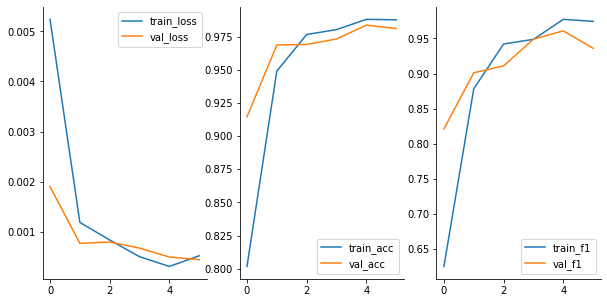

In [51]:
show_graph(train_loss_history, train_acc_history, train_f1_history,
           val_loss_history, val_acc_history, val_f1_history)

## Inference 과정

In [42]:
# sumission_dir 생성
my_make_dir(cfg.submission_dir)

## 6.1 Test Dataset 정의

In [43]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = np.array(Image.open(self.img_paths[index]))

        if self.transform:
            image = self.transform(image=image)
            image = image['image']
        return image

    def __len__(self):
        return len(self.img_paths)

In [49]:
sorted(glob.glob(os.path.join(cfg.model_save_path, cfg.model_name) + '_*/checkpoint.pt'))

['/opt/ml/code/model/efficientnet_b4_1/checkpoint.pt',
 '/opt/ml/code/model/efficientnet_b4_2/checkpoint.pt',
 '/opt/ml/code/model/efficientnet_b4_3/checkpoint.pt',
 '/opt/ml/code/model/efficientnet_b4_4/checkpoint.pt',
 '/opt/ml/code/model/efficientnet_b4_5/checkpoint.pt']

In [56]:
test_transform = albumentations.Compose([
    albumentations.Resize(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE),
    albumentations.Normalize(cfg.mean_list, cfg.std_list, max_pixel_value=255.0, p=1.0),
    ToTensorV2(p=1.0),
])

In [91]:
# 테스트셋 추론 메인 코드

# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(cfg.test_dir, 'info.csv'))
image_dir = os.path.join(cfg.test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

dataset = TestDataset(image_paths, test_transform)

loader = DataLoader(
    dataset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    num_workers=cfg.NUM_WORKERS,
)

# KFOLD를 이용한 모델 5개의 checkpoint.pt path
checkpoint_path_list = sorted(glob.glob(os.path.join(cfg.model_save_path, 
                                                     cfg.model_name) + '_*/checkpoint.pt'))
for i, checkpoint_path in enumerate(checkpoint_path_list):
    # 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
    model = ImgClassifier(model_name=cfg.model_name, 
                          n_class=cfg.CLASS_NUM, 
                          pretrained=False).to(device)
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()

    # 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
    all_predictions = []
    for images in tqdm(loader):
        with torch.no_grad():
            images = images.to(device)
            pred = model(images)
            pred = pred.argmax(dim=-1)
            all_predictions.extend(pred.cpu().numpy())
    submission['ans'] = all_predictions

    # 제출할 파일을 저장합니다.
    submission.to_csv(os.path.join(cfg.submission_dir, 
                                   'submission_{}.csv'.format(checkpoint_path.split('/')[-2])), 
                      index=False)
    
    print(f'{i + 1} 번째 sumission file 생성!')
print('test inference is done!')

100%|██████████| 99/99 [00:20<00:00,  4.89it/s]


1 번째 sumission file 생성!


100%|██████████| 99/99 [00:20<00:00,  4.88it/s]


2 번째 sumission file 생성!


100%|██████████| 99/99 [00:20<00:00,  4.88it/s]


3 번째 sumission file 생성!


100%|██████████| 99/99 [00:20<00:00,  4.85it/s]


4 번째 sumission file 생성!


100%|██████████| 99/99 [00:20<00:00,  4.87it/s]

5 번째 sumission file 생성!
test inference is done!


In [92]:
submisson_file_list = glob.glob(os.path.join(cfg.submission_dir, 'submission_*'))

In [94]:
for i, file in enumerate(submisson_file_list):
    if i == 0:
        result_df = pd.read_csv(file)
        result_df.rename({'ans': 'ans_1'}, axis=1, inplace=True)
    else:
        temp_df = pd.read_csv(file)
        result_df['ans_{}'.format(i + 1)] = temp_df['ans']
        
result_df['ans'] = result_df.apply(lambda x: x.iloc[1:].value_counts().index[0], axis=1)
result_df.drop(['ans_{}'.format(i) for i in range(1, 6)], axis=1, inplace=True)
result_df.to_csv(os.path.join(cfg.submission_dir, 
                              'submission_{}_ensemble.csv'.format(cfg.model_name)),
                 index=False)